# Séance 1: notions de filtrage pour le traitement d'images

#  Transformée de Fourier pour les images

La transformée de Fourier est un outil omniprésent d'analyse du signal qui permet de passer du domaine spatial (ou temporel) au domaine fréquentiel. Dans le cas du son, la transformée de Fourier va permettre d'extraire les fréquences qui représentent différents types de variations d'intensité sonores : les basses fréquences représentent les graves (variations lentes), les hautes fréquences représentent les aigus (variations rapides).

Pour une image, le signal est bidimensionnel. Les fréquences faibles représentent de grandes surfaces homogènes avec peu de changements d'intensité (ou de couleur) tandis que les hautes fréquences représentent des changements brusques d'intensité, comme les contours des objets ou des turbulences.

Rappelons (?) que mathématiquement, la transformée de Fourier d'un signal réel 1D $f$ est la fonction $\hat{f}$ :

$$\hat{f}(\nu) = \int_{-\infty}^{+\infty} f(x) e^{-2i\pi x \nu} dx$$

On suppose dans cette définition que $f$ est intégrable sur $\mathbb{R}$.

En pratique on travaille sur des signaux numériques discrets (et donc pas continus). On utilise alors la Transformée de Fourier Discrète (TFD) qui s'obtient par :

$$\hat{f}[k] = \frac{1}{N} \sum_{j=0}^{N-1} f[j] e^{-2i\pi j \frac{k}{N}}$$

pour $f$ un signal discret à $N$ valeurs.

Pour un signal bidimensionnel (comme une image) défini sur une grille $H\times W$, on peut généraliser cette définition et écrire la Transformée de Fourier Discrète 2D :

$$\hat{f}[k_x, k_y] = \frac{1}{H W} \sum_{p=0}^{H-1} \sum_{q=0}^{W-1} f[p, q] \exp\left(-2i\pi \left(\frac{p \cdot k_x}{H} + \frac{q \cdot k_y}{W}\right)\right)$$

Autrement dit, la transformée de Fourier d'une image $I$ est une image **complexe** $\hat{I}$ de mêmes dimensions.

Mettons ceci en pratique.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import skimage

plt.rcParams['figure.figsize'] = (10, 10)

Nous allons utiliser deux images d'exemple pour mieux interpréter l'effet de la transformée de Fourier :
- un rectangle blanc sur fond noir,
- une photo en niveaux de gris.

Une fois n'est pas coutume, utilisons une image d'un animal mignon qui n'est pas un chat.

In [ ]:
from scipy import misc
rect = np.zeros((100, 100))
rect[45:55, 40:60] = 1.
img = misc.face(gray=True) # ignorons la couleur pour l'instant
fig = plt.figure()
fig.add_subplot(121) and plt.imshow(rect, cmap="gray")
fig.add_subplot(122) and plt.imshow(img, cmap="gray") and plt.show()

L'algorithme de la transformée de Fourier rapide (FFT) existe également pour le cas 2D. Nous n'allons pas l'implémenter nous-mêmes mais plutôt utiliser les outils disponibles dans `SciPy`.

`fft2` et `ifft2` correspondent ainsi à la transformée de Fourier rapide en 2D et à son inverse.

In [ ]:
# Transformée de Fourier sur les images
from scipy.fft import fft2, ifft2
from scipy.fft import fftshift, ifftshift

fourier = fft2(rect)
print(f"La transformée de Fourier de l'image du carré est une matrice "
      f"de type {fourier.dtype} et de dimensions {fourier.shape}")

La transformée de Fourier produit un résultat en complexe. Ce qui nous intéresse le plus souvent est de savoir quelle est l'amplitude de chacun de ses coefficients (c'est-à-dire la norme du complexe associé) car celle-ci est liée à l'énergie de la fréquence considérée. La norme du complexe s'obtient avec `np.abs` :

In [ ]:
fourier_amplitude = np.abs(fourier)
plt.imshow(fourier_amplitude, cmap="magma") and plt.show()

Cette visualisation n'est pas idéale car l'origine (0,0) se trouve en haut à gauche (remarquez que les coins sont symétriques ! comme pour une transformée de Fourier 1D où l'on observe une symétrie par rapport à l'origine). La fonction `fftshift` permet de décaler la visualisation de sorte à mettre l'origine au centre de l'image :

In [ ]:
fourier_amplitude = np.abs(fftshift(fourier))
plt.imshow(fourier_amplitude, cmap="magma") and plt.show()

**Question** : qu'observe-t-on ? Pourquoi ? (raisonner par analogie avec le cas d'un signal rectangulaire 1D)

On peut réaliser le même test avec une image constante :

In [ ]:
gray = 0.5 * np.ones((100, 100))

def plot_image_fourier(image, log=False, figsize=(12, 6)):
    # Conversion en niveaux de gris si l'image est en couleurs
    if len(image.shape) == 3 and image.shape[-1] == 3:
        from skimage.color import rgb2gray
        image = rgb2gray(image)
    fourier = np.abs(fftshift(fft2(image)))
    if log:
        fourier = np.log(fourier + 1e-3)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    ax[0].imshow(image, cmap="gray", vmin=0., vmax=1.)
    ax[0].set_title("Image")
    ax[1].imshow(fourier, cmap="magma")
    ax[1].set_title("Transformée de Fourier")
    plt.show()

plot_image_fourier(gray)

**Question :** qu'observe-t-on ? Pourquoi ? (raisonner par analogie avec un signal constant 1D)

Maintenant que nous comprenons un peu mieux la généralisation de la transformée de Fourier aux signaux 2D, passons à notre image de raton-laveur. Comme nous l'avons dit, la transformée de Fourier est une image complexe, on ne peut pas la visualiser directement. On peut s'inspirer des techniques de visualisation de spectre dans le cas 1D. On va donc calculer la norme de chaque coefficient du spectre 2D et en afficher le logarithme :

In [ ]:
plt.imshow(np.log(np.abs(fftshift(fft2(img)))), cmap="magma") and plt.show()

Un (léger) problème de cette façon de faire est que la transformée de Fourier fait l'hypothèse que le signal observé correspond à une période d'un signal périodique. Ce n'est bien entendu pas le cas pour les images mais cela introduit une discontinuité (et donc des hautes fréquences) aux bords de l'image. La « croix » est provoquée par ces discontinuités. Une façon de s'en débarasser est d'utiliser un fenêtrage qui réduit l'impact des bords :

In [ ]:
from skimage.filters import window
from skimage.util import img_as_float
image = img_as_float(img)

wimage = image * window('hann', image.shape)
plt.imshow(wimage, cmap="gray") and plt.show()

Cela permet de mieux mettre en évidence le spectre réel de l'image :

In [ ]:
plt.imshow(np.log(np.abs(fftshift(fft2(wimage)))), cmap="magma") and plt.show()

Nous verrons par la suite l'effet de différents filtres sur la transformée de Fourier (et comment interpréter certains noyaux de convolution du point de vue fréquentiel). 

## Convolution avec un noyau

On rappelle que pour deux signaux réels, on note $*$ le produit de convolution défini par :
$$(f*g)(x) = \int_{-\infty}^{+\infty} f(x-t)g(t) dt$$

et sa version discrète :
$$(f*g)[k] = \sum_{p=-\infty}^{+\infty} f[x - p] g[p]$$

Une propriété intéressante de la transformée de Fourier est qu'elle transforme la convolution en produit, c'est-à-dire qu'en notant $\mathcal{F}$ la transformée de Fourier :

$$\mathcal{F}(f * g) = \mathcal{F}(f) \cdot \mathcal{F}(g)$$

Dans le cas 2D (pour des images, donc), on peut écrire la convolution bidimensionnelle comme le produit entre une image $I$ de dimensions $(H, W)$ et un noyau $K$ de dimensions $(k_h, k_w)$. On définit alors le filtre $\mathcal{K}$ comme étant le résultat de la convolution de $I$ par $K$:

$$\mathcal{K}(I)[m,n] = K * I[m, n] = \sum_{i=-p}^{+p} \sum_{j=-q}^{+q} I[m - i, n -j] \cdot K[i,j]$$

où $p = \frac{k_h - 1}{2}$ et $q = \frac{k_w - 1}{2}$.

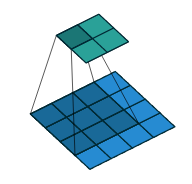

# Filtrage d'images numériques

Le filtrage est un élément fondamental du traitement du signal. Comme nous l'avons vu précédemment, une image numérique est un signal 2D discrétisé sur lequel nous pouvons utiliser toutes les techniques classiques d'analyse. Et nous n'allons pas nous en priver…

## Gradients

Si l'on considère une image en niveaux de gris $I$ comme une fonction $(x,y) \rightarrow p \in \mathbb{R}$, alors on peut considérer les *gradients* d'une image, c'est-à-dire ses dérivées partielles selon $x$ et selon $y$. On note conventionnellement $\nabla I$ le gradient de $I$:

$$\nabla I=\begin{bmatrix}
                g_{x} \\
                g_{y}
                \end{bmatrix} = \begin{bmatrix}
                \frac{\partial f}{\partial x} \\
                \frac{\partial f}{\partial y}
            \end{bmatrix}
$$

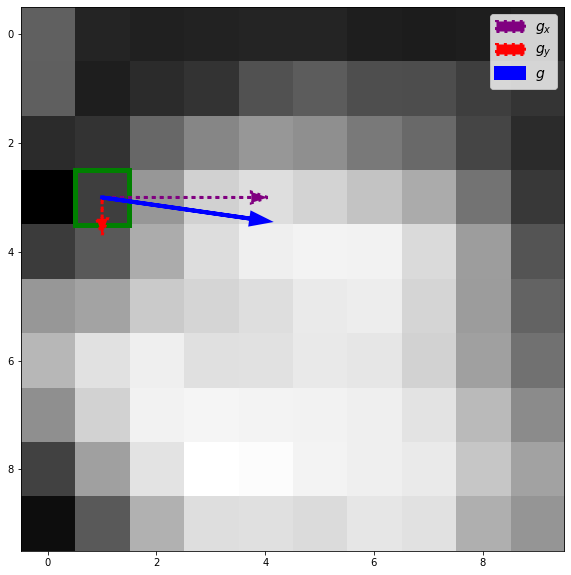

Néanmoins, comme $I$ prend ses valeurs sur une grille discrète (et finie) de pixels, il n'est pas possible de calculer le gradient réel. En revanche, il est possible d'utiliser la méthode des différences finies pour estimer le gradient :

$$g_x[i,j] = I[i+1, j] - I[i, j]$$
$$g_y[i,j] = I[i, j + 1] - I[i, j]$$

Pour rappel, la méthode des différences finies permet de calculer une approximation de la dérivée d'une fonction en utilisant la définition de la dérivée d'une fonction $f$ :
$$f'(x) = \lim_{\varepsilon \rightarrow 0} \frac{f(x+\varepsilon) - f(x)}{\varepsilon}$$

Pour $\varepsilon$ fixe, on obtient alors :

$$\Delta_h[f](x) = \frac{1}{\varepsilon} \left(f(x + \varepsilon) - f(x)\right)$$

Dans notre cas, $\varepsilon = 1$, ce qui donne l'expression ci-dessus.

Le plus souvent, on va s'intéresser à la norme du gradient, c'est-à-dire à :
$$\mathbf{G} = \| \nabla I \| = \sqrt{g_x^2 + g_y^2}$$

Outre la norme du gradient, il peut être intéressant de regarder sa direction, c'est-à-dire son angle:
$$\theta = \tan^{-1} \left(\frac{g_y}{g_x}\right)$$

C'est une propriété que nous allons peu utiliser mais qui peut être pratique dans certaines situations.

### Gradients et convolution

En pratique, on reformule généralement le gradient par différences finies selon $x$ et $y$ par un produit de convolution entre l'image $I$ et un noyau adapté :

$$\frac{\partial f}{\partial x} = \begin{bmatrix} -1 +1 \end{bmatrix} * \mathbf{I}$$
$$\frac{\partial f}{\partial y} = \begin{bmatrix} -1 \\+1 \end{bmatrix} * \mathbf{I}$$

Cette formulation n'est pas idéale (elle décale l'image d'un demi-pixel) et on préfère un filtre $3\times1$ avec un 0 au centre :
$$\begin{bmatrix}-1\\ 0\\ +1\end{bmatrix}$$

ce qui revient à réécrire le gradient comme :
$$g_x[i,j] = I[i+1, j] - I[i-1, j]$$
$$g_y[i,j] = I[i, j + 1] - I[i, j-1]$$

On peut également calculer les gradients selon les diagonales en utilisant les noyaux suivants :
    
$$\begin{bmatrix}+1 & 0\\ 0 & -1\end{bmatrix} \quad\text{et}\quad \begin{bmatrix}0 & +1\\ -1 & 0\end{bmatrix}$$.

On appelle parfois ces noyaux de convolution les filtres de Roberts (du nom de l'ingénieur Lawrence Roberts qui les a proposés en 1963). 

### Prewitt

Pour calculer le gradient, on peut réaliser la convolution avec les noyaux ci-dessus mais on va généralement utiliser un noyau de la forme :

$$\mathbf{G}_{\text{horizontal}} = \begin{bmatrix} 
                -1 & -1 & -1 \\
                0 & 0 & 0 \\
                +1 & +1 & +1
\end{bmatrix} * \mathbf{I}$$

Ce noyau est appelé filtre de Prewitt (du nom de son inventrice). Il s'écrit de la façon suivante avec NumPy :

In [ ]:
top_prewitt = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])

Pour l'appliquer à notre image, `scipy` fournit des outils de base pour réaliser une convolution en 2D :

In [ ]:
from scipy.signal import fftconvolve, convolve2d

In [ ]:
filtered = convolve2d(img, top_prewitt)
plt.imshow(filtered, cmap="gray") and plt.show()

On peut filtrer l'image des gradients pour ne conserver que les gradients horizontaux qui dépassent une certaine intensité :

In [ ]:
plt.imshow(filtered > 100, cmap="gray") and plt.show()

**Question** : en vous basant sur l'écriture du filtre de Prewitt horizontal ci-dessus, écrire le filtre de Prewitt vertical. L'appliquer sur l'image et visualiser le résultat.

## Flou

Le flou est un concept général de traitement d'image qui designe la perte de **netteté**, c'est-à-dire la difficulté, voire l'impossibilité, de distinguer des détails de l'image. Il existe différents types de flou qui ne sont pas provoqués par le même phénomène.

### Flou moyen (*box blur*)

En général, le phénomène de floutage apparaît lorsque la valeur d'un pixel « déborde » sur ses voisins. Concrètement, la valeur d'un pixel ne correspond plus exactement à un endroit précis de l'espace, mais à un mélange de couleurs obtenu en additionnant plusieurs pixels d'une même région.

Le flou le plus simple est par conséquent le flou moyen, qui pour chaque pixel associe la moyenne des valeurs de ses voisins à distance au plus $k$ :

$$\tilde{I}[i,j] = \frac{1}{k^2} \sum_{p={-k/2}}^{k/2} \sum_{q={-k/2}}^{k/2} I[p,q]$$

Cela revient à réaliser une convolution par un noyau dont la matrice ne contient que des 1. Par exemple, pour un flou moyen $3\times3$, le filtre correspondant est obtenu par le noyau :

$$\frac{1}{9}\begin{bmatrix} 1 & 1 & 1 \\ 1 & 1 & 1 \\ 1 & 1 & 1 \end{bmatrix}$$

*Note*: en anglais, on appelle ce type de filtre un *box linear filter*, d'où le nom *box blur*.

En utilisant la fonction `convolve2d` de SciPy, nous pouvons visualiser l'effet d'un tel flou moyen sur notre image de raton-laveur :

In [ ]:
k = 10
box_filter = np.ones((k, k)) * 1/k * 1/k
filtered = convolve2d(img, box_filter, mode="same")
plt.imshow(filtered, cmap="gray") and plt.show()

Nous pouvons ensuite examiner l'effet de ce floutage dans le domaine fréquentiel :

In [ ]:
plt.imshow(np.log(np.abs(fftshift(fft2(filtered)))), cmap="magma") and plt.show()

Ce résultat vous surprend-il ? Pourtant rappelons-nous que la transformée de Fourier d'un rectangle produit un sinus cardinal selon $x$ et $y$. La convolution entre deux images (ou une image et un noyau) correspond à un produit dans l'espace de Fourier. Le spectre 2D de l'image filtrée correspond donc au produit du spectre de l'image originale et du spectre du filtre rectangulaire !

In [ ]:
w, h = img.shape
# Filtre rectangulaire k x k
box = np.zeros_like(img)
box[w//2 - k//2: w//2 + k//2 + 1, h//2 - k//2: h//2 + k//2 + 1] = 1.


# Transformée de Fourier
fourier = fftshift(np.log(np.abs(fft2(img))))
fourier_box = fftshift(np.abs(fft2(box)))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
ax[0,0].imshow(img, cmap="gray")
ax[0,0].set_title("Image")
ax[1,0].imshow(box, cmap="gray")
ax[1,0].set_title("Filtre")
ax[0,1].imshow(fourier, cmap="magma")
ax[0,1].set_title("Image (domaine fréquentiel, échelle log)")
ax[1,1].imshow(fourier_box, cmap="magma")
ax[1,1].set_title("Filtre (domaine fréquentiel)")
plt.show()

### Flou gaussien

Le flou gaussien est un flou particulièrement utilisé pour lisser une image. En 2D, le noyau gaussien correspondant est la matrice $G$ telle que :
$$G_{p,q} = \frac{1}{2\pi\sigma^2} \exp\left(-\frac{(p-p_0)^2 + (q-q_0)^2}{2\sigma^2}\right)$$

c'est-à-dire que chaque ligne et chaque colonne de la matrice correspondant à la densité de probabilité d'une loi normale centrée en $(p_0, q_0)$ et d'écart-type $\sigma$. En pratique, on réalise une approximation de ce noyau en considérant une matrice de taille $k \times k$ et on laisse tomber les valeurs $G_{p,q}$ si $p \gt k$ ou $q \gt k$ (si $k$ est assez grand par rapport à $\sigma$, ces valeurs sont proches de zéro de toute façon).

L'intérêt de ce filtre est que la transformée de Fourier d'une gaussienne est encore une gaussienne. Un flou gaussien va donc réduire les composantes haute fréquence : c'est un filtre passe-bas (d'où son utilisation pour le lissage).

### Flou cinétique

Le flou cinétique (ou flou de mouvement) est le flou provoqué sur la photographie par le mouvement de l'objet lors du temps de pose.

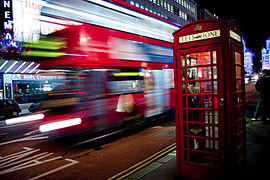

Il est difficile de donner un modèle général de filtre de convolution qui permet de reproduire le flou cinétique car celui-ci dépend du mouvement du sujet photographié. Le problème est que s'il y a plusieurs sujets (imaginez une voiture et des piétons), ces derniers peuvent bouger de différentes façons, indépendamment les uns des autres !

### Flou de bougé

Le flou de bougé correspond au déplacement **de l'appareil** pendant l'exposition de la photographie (tremblements, instabilité, mouvement de l'objectif, etc.). Contrairement au flou cinétique, ce flou s'applique de façon globale sur toute l'image à la fois. Mais les déplacements peuvent être complexes (translation + rotation, pas forcément à vitesse constante).

Pour des mouvements simples, on peut toutefois tenter de deviner un noyau approximatif. Par exemple, le noyau ci-dessous simule grossièrement un mouvement de translation à 45° où chaque pixel s'est déplacé d'environ 1 pixel durant le temps d'exposition:

$$\frac{1}{3}\begin{bmatrix} 0 & 0 & 1 \\ 0 & 1 & 0 \\ 1 & 0 & 0 \end{bmatrix}$$

c'est-à-dire que l'on a déplacé l'appareil à 45° pendant la prise de la photo.

In [ ]:
k = 10 # changez la valeur de k pour modifier l'intensité du mouvement
box_filter = 1./k * np.eye(k)[::-1]
filtered = convolve2d(img, box_filter, mode="same")
plt.imshow(filtered, cmap="gray") and plt.show()

## Filtrage avec `scikit-image`

Tous les filtres que nous avons vu précédemment sont préintégrés dans `scikit-image` qui propose en effet le bien nommé sous-module `filters`. Pas besoin donc de redéfinir les noyaux ou d'effectuer la convolution avec `scipy`, notre bibliothèque va le faire pour nous !

### Flou gaussien

Le flou gaussien est implémenté dans `skimage.filters.gaussian`. Le principal paramètre est `sigma` qui correspond au $\sigma$ (l'écart-type) du noyau gaussien :

In [ ]:
from skimage import filters

filtered = filters.gaussian(image, sigma=2)
plt.imshow(filtered, cmap="gray") and plt.show()

Dans l'espace de Fourier, on peut constater que l'intensité des composantes spectrales décroit fortement pour les hautes fréquences (dans les coins) :

In [ ]:
plt.imshow(np.log(np.abs(fftshift(fft2(filtered)))), cmap="magma") and plt.show()

### Sobel

Une alternative à l'opérateur de Prewitt est le filtre de Sobel, proposé par Sobel et Feldman en 1968. Son écriture est légèrement différente mais le principe est identique :

$$\mathbf{G}_x = \begin{bmatrix} 
 +1 & 0 & -1  \\
+2 & 0 & -2 \\
+1 & 0 & -1 
\end{bmatrix} * \mathbf{I}
\quad;\quad
\mathbf{G}_y = \begin{bmatrix} 
 +1 & +2 & +1\\
 0 & 0 & 0 \\
-1 & -2 & -1
\end{bmatrix} * \mathbf{I}$$

Le filtre de Sobel est au filtre de Prewitt ce que le filtre triangulaire est au filtre rectangulaire pour les signaux 1D.

Il est très simple d'application avec `skimage`. Il est possible d'utiliser soit `sobel_h` et `sobel_v` pour obtenir les gradients horizontaux et verticaux, soit directement `sobel` si l'on ne s'intéresse qu'à l'amplitude du gradient :

In [ ]:
gradients_h = filters.sobel_h(image)
gradients_v = filters.sobel_v(image)
gradients = filters.sobel(image)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
ax[0].imshow(gradients_h, cmap="gray")
ax[0].set_title("Gradient horizontaux")
ax[0].axis("off")
ax[1].imshow(gradients_v, cmap="gray")
ax[1].set_title("Gradient verticaux")
ax[1].axis("off")
ax[2].imshow(gradients, cmap="gray")
ax[2].set_title("Norme de $G$")
ax[2].axis("off")
plt.show()

## Bruit et qualité d'image

Nous avons vu précédemment que le flou est une source possible de dégradation de la qualité d'image. Mais ce n'est pas la seule. Outre la perte de netteté, une image peut souffrir de la présence de bruit. Celui-ci se traduit par la présence de grains et d'artefacts qui peuvent réduire le contraste, masquer des détails etc.

Illustrons quelques-uns des différents types de bruit qui peuvent survenir en imagerie numérique (et comment essayer de s'en débarasser). La photo que nous allons utiliser pour ce test est une photo du lancement d'une fusée Falcon 9 de SpaceX.

In [ ]:
rocket = skimage.data.rocket()
plt.imshow(rocket) and plt.show()

### Bruit thermique (Johnson-Nyquist)

Ce bruit est provoqué par les imperfections du capteur. Dans un appareil photo numérique, l'image est capturée par une matrice 2D de pixels qui transforme les photons reçus pour chaque cellule en courant électrique. La température de l'appareil et le bruit électrique introduisent un courant non-désiré qui perturbe légèrement la valeur de l'intensité du pixel.

On modélise couramment ce bruit par un bruit gaussien additif, c'est-à-dire que le pixel bruité est obtenu par:

$$\tilde{I}[i,j] = I[i,j] + \varepsilon \quad \text{avec} \quad \varepsilon \sim \mathcal{N}(0, \sigma)$$

Sur une image grise, cela donne le bruit suivant :

In [ ]:
from skimage.util import random_noise

pure_noise = random_noise(0.5*np.ones((100, 100)), seed=0)
plt.imshow(pure_noise, cmap="gray") and plt.show()

En couleur, ce bruit s'ajoute de façon indépendante sur chaque composante :

In [ ]:
rocket_gaussian = random_noise(rocket, mode="gaussian", seed=0)
plt.imshow(rocket_gaussian) and plt.show()

Dans le domaine fréquentiel, l'ajout du bruit gaussien revient à ajouter un bruit blanc gaussien additif sur l'image. 

In [ ]:
plot_image_fourier(pure_noise, log=True, figsize=(16, 8))

In [ ]:
plot_image_fourier(rocket, log=True, figsize=(16, 8))

In [ ]:
plot_image_fourier(rocket_gaussian, log=True, figsize=(16, 8))

### Bruit poivre et sel

Ce bruit est provoqué généralement par une erreur de transmission, une corruption des données lors du stockage ou de poussières fines sur le capteur au moment de l'acquisition. Dans le cas d'une image en niveaux de gris, ce bruit se matérialise par des pixels blancs saturés (sel) ou parfaitement noirs (poivre). On parle ainsi de bruit **impulsionnel**.

Voici son effet sur une image grise :

In [ ]:
pure_noise = random_noise(0.5*np.ones((100, 100)), mode="s&p", seed=0)
plt.imshow(pure_noise, cmap="gray") and plt.show()

Comme pour le bruit thermique, ce bruit s'ajoute de façon indépendante sur chaque composante lorsque l'image est en couleur. Notez que le bruit impulsionnel poivre et sel est nettement plus piqué que le bruit gaussien.

In [ ]:
rocket_sp = random_noise(rocket, mode="s&p")
plt.imshow(rocket_sp) and plt.show()

### Débruitage par filtre médian

Face à la présence de bruit dans une image numérique, une question naturelle à se poser est : peut-on retirer le bruit pour retrouver l'image de départ ? En règle générale la réponse est non. En revanche, il est souvent possible de retirer une partie du bruit pour obtenir une version approchée de l'image désirée.

Dans le cas du bruit impulsionnel, un filtre particulièrement efficace est le **filtre médian**. Contrairement aux filtres que nous avons vu précédemment, le filtre médian ne peut pas s'exprimer sous forme de convolution : il s'agit d'un filtre non-linéaire.

En effet, l'application du filtre médian consiste à remplacer chaque pixel dans un voisinage $k \times k$ par la valeur médiane des pixels de ce voisinage :

$$I_\text{filtrée}[i,j] = \operatorname{m}_{i-k/2 \leq p,q \leq i+k/2} (I[p,q])$$ où $m$ désigne l'opérateur statistique de calcul de la médiane.

Il est bien sûr implémenté par `skimage`. Par défaut, il s'applique sur un carré $3\times3$ mais il est possible de définir d'autres voisinages en changeant l'élément structurant `selem` (nous verrons dans un TP suivant à quoi cela correspond).

In [ ]:
from skimage import filters

pure_noise_denoised = filters.median(pure_noise)
plt.imshow(pure_noise_denoised, cmap="gray", vmax=1.0, vmin=0.0) and plt.show()

Et sur notre image de fusée :

In [ ]:
rocket_denoised = filters.median(rocket_sp)
plt.imshow(rocket_denoised) and plt.show()

Nous pouvons vérifier dans le domaine fréquentiel l'effet du débruitage par filtre médian :

In [ ]:
plot_image_fourier(rocket, log=True, figsize=(16, 8))

In [ ]:
plot_image_fourier(rocket_sp, log=True, figsize=(16, 8))

In [ ]:
plot_image_fourier(rocket_denoised, log=True, figsize=(16, 8))

### Débruitage par filtre gaussien

Puisque le bruit tend à ajouter des composantes dans les hautes fréquences et que le filtre gaussien lisse justement l'image et élimine les hautes fréquences, il paraît naturel de vouloir utiliser le flou gaussien comme technique de débruitage.

In [ ]:
plt.imshow(filters.gaussian(rocket_gaussian, sigma=0.5)) and plt.show()

**Question** : jusqu'à quelle valeur de sigma faut-il monter pour faire disparaître le bruit gaussien complètement ? Le bruit impulsionnel ? Le résultat est-il satisfaisant ? Pourquoi ?

### Autres débruitages

Il existe de nombreuses méthodes de débruitage, notamment dans le cadre du bruit gaussien. L'objectif n'est pas ici d'être exhaustif mais mentionnons deux familles de méthodes plutôt importantes.

Une approche alternative au filtre médian pour le débruitage est le filtrage bilatéral. Il s'agit d'un autre type de filtre non-linéaire qui s'attache notamment à préserver les contours présents dans l'image, de sorte à éliminer les hautes fréquences *dues au bruit* mais pas celles liées au gradient naturel de l'image. Cette méthode est implémentée dans `skimage` dans le module `restoration` :

In [ ]:
from skimage import restoration

rocket_tv = restoration.denoise_bilateral(rocket_gaussian, channel_axis=2, sigma_color=0.05, sigma_spatial=2)
plt.imshow(rocket_tv) and plt.show()

Une autre approche repose sur le constant suivant : une image naturellement comporte relativement peu de gradients hors des espaces de transition. Mais une image bruitée se retrouve avec des gradients un peu partout où du bruit a été ajouté. Par conséquent, la quantité de gradients dans une image bruitée est plus élevée que dans une image non-bruitée.

On peut préciser cette quantité en définissant la **variation totale** (*total variation*) comme étant la somme des intensités des gradients de toute l'image :
$$V(I) = \sum_{i,j} \sqrt{G_x[i,j]^2 + G_y[i,j]^2}$$

Le débruitage par variation totale consiste alors à trouver une image $\hat{I}$ proche de l'image $I$ mais qui minimise la variation totale, c'est-à-dire la quantité de gradients dans l'image. Minimiser cette quantité n'est pas évident, l'algorithme le plus utilisé (dit Rudin-Osher-Fatemi) fait appel à des équations aux dérivées partielles. On ne détaillera donc pas son fonctionnement (mais sachez que cet algorithme a été une des pièces importantes pour l'acquisition de la première image d'un trou noir !).

In [ ]:
rocket_tv = restoration.denoise_tv_chambolle(rocket_gaussian, channel_axis=2)
plt.imshow(rocket_tv) and plt.show()

En pratique, le *total variation denoising* à tendance à générer des images constantes par morceaux, c'est-à-dire des grandes zones homogènes et des ruptures de couleur très localisées. Cela peut ainsi donner un effet *cartoon* non désiré aux images.

## Amélioration de la netteté

Le nom de ce filtre est trompeur car il permet plutôt d'améliorer le contraste entre les zones sombres et les zones claires d'une image. Il existe plusieurs noyaux de netteté similaires, par exemple :

$$\begin{bmatrix}
\ \ 0 & -1 & \ \ 0 \\
-1 & \ \ 5 & -1 \\
\ \ 0 & -1 & \ \ 0
\end{bmatrix}$$

ou encore 

$$\begin{bmatrix}
\ \ -1/9 & -1/9 & \ \ 1/9 \\
-1/9 & \ \ +1 & -1/9 \\
\ \ -1/9 & -1/9 & \ \ -1/9
\end{bmatrix}$$

Ce type de noyau de convolution correspond en réalité à un filtre passe-haut (c'est-à-dire qui retire les basses fréquences) :

In [ ]:
from skimage.transform import rescale
img_small = rescale(img, scale=0.1)
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(img_small, cmap="gray")
sharpen = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
sharpen = np.array([[-1/9, -1/9, -1/9], [-1/9, 1, -1/9], [-1/9, -1/9, -1/9]])
filtered = convolve2d(img_small, sharpen, mode="same")
fig.add_subplot(122)
plt.imshow(filtered, cmap="gray") and plt.show()

In [ ]:
plot_image_fourier(img_small, log=True, figsize=(14, 8))

In [ ]:
plot_image_fourier(filtered, log=True, figsize=(14, 8))

# Détection de contours

Une tâche classique en traitement d'images est la détection des contours. Par contour, on entend les zones où la luminosité de l'image change brutalement (i.e. les pixels correspondant à des discontinuités). Il s'agit d'une brique de base pour de nombreuses applications en détection et segmentation d'objets car les contours sont la première marche vers la délinéation.

Avec ce que nous avons appris jusqu'ici, nous avons de quoi implémenter nos premiers algorithmes robustes pour la détection de contours.

## Par la méthode des gradients

Vous l'aurez peut-être déjà remarqué, les gradients 2D que nous avons calculé permettent déjà de détecter les zones de changement brusque d'intensité… et notamment les contours des objets. En effet, une variation importante d'intensité sur peu de pixels produit une valeur élevée du gradient. Comme les variations rapides de couleur sont souvent associées à une transition d'un objet à un autre, les gradients sont donc « presque » des détecteurs de contours.

Voyons voir comment exploiter les gradients pour en faire des contours.

Commençons par calculer les gradients verticaux et horizontaux à l'aide d'un filtrage de Prewitt ou de Sobel. Précédemment nous avons utilisé `scipy` et une approche bas niveau pour ce faire mais nous pouvons gagner du temps et le faire directement avec `scikit-image`:

In [ ]:
from skimage import filters
from skimage import io

picsou = io.imread("images/picsou.jpg", as_gray=True)
gradient_h = filters.prewitt_h(picsou)
gradient_v = filters.prewitt_v(picsou)
gradient = np.sqrt(gradient_h**2 + gradient_v**2)

fig = plt.figure(figsize=(18, 6))
fig.add_subplot(141)
plt.imshow(picsou, cmap="gray")
plt.title("Image")
fig.add_subplot(142)
plt.imshow(gradient_h, cmap="gray")
plt.title("Gradients horizontaux")
fig.add_subplot(143)
plt.imshow(gradient_v, cmap="gray")
plt.title("Gradients verticaux")
fig.add_subplot(144)
plt.imshow(gradient, cmap="gray")
plt.title("Norme des gradients")
plt.show()

Ou directement :

In [ ]:
gradient = filters.sobel(picsou)
fig = plt.figure(figsize=(8, 6))
fig.add_subplot(121)
plt.imshow(picsou, cmap="gray")
plt.title("Image")
fig.add_subplot(122)
plt.imshow(gradient, cmap="gray")
plt.title("Norme des gradients")
plt.show()

**Question** : que se passe-t-il dans les zones avec beaucoup de détails (comme les sapins ou la tenue de Picsou) ?

On peut ensuite seuiller sur la norme des gradients pour ne conserver que les zones de fortes transitions et donc les contours. Par exemple, ci-dessous on ne conserve que les gradients qui correspondent au 90e percentile (c'est-à-dire les 10% des gradients les plus intenses) :

In [ ]:
plt.imshow(gradient > np.percentile(gradient, 90), cmap="gray") and plt.show()

Pour se débarasser du problème, une astuce couramment employée consiste à flouter légèrement l'image avec un noyau gaussien. Le filtre gaussien étant passe-bas, ce dernier va retirer les hautes fréquences et donc lisser l'image. La détection de contours par la méthode de Sobel aura donc une réponse plus faible dans les zones bruitées, ce qui facilitera l'identification des « vraies » contours.

In [ ]:
blurred = filters.gaussian(picsou, sigma=3)
gradient = filters.sobel(blurred)
fig = plt.figure(figsize=(16, 8))
fig.add_subplot(131)
plt.imshow(picsou, cmap="gray")
plt.title("Image")
fig.add_subplot(132)
plt.imshow(gradient, cmap="gray")
plt.title("Norme des gradients")
fig.add_subplot(133)
q = 90
plt.title(f"Seuillage au {q}e percentile")
plt.imshow(gradient > np.percentile(gradient, q), cmap="gray") and plt.show()
plt.show()

## Filtre de Canny

Le filtre de Canny est une version améliorée de la détection des contours par la méthode des gradients. Cet algorithme se déroule en quatre étapes :
1. réduction du bruit par un lissage gaussien,
2. calcul des normes et des angles des gradients,
3. suppression des gradients non-maximaux,
4. seuillage par hystérésis.

L'étape 1 est parfaitement identique à ce que nous avons réalisé précédemment (application d'un noyau gaussien de paramètre $\sigma$ à définir).

L'étape 2 est également analogue, les gradients étant calculés par l'application des opérateurs de Sobel horizontaux et verticaux.

L'étape 3 est un peu plus complexe et consiste à amincir les contours obtenus de sorte à n'obtenir que des contours de 1 pixel d'épaisseur :
- pour chaque point, on cherche la normale (perpendiculaire au à la tangente du contour, que l'on obtient à partir de l'angle du gradient),
- on obtient 4 catégories de points : les contours horizontaux, verticaux, diagonaux et antidiagonaux,
- pour chaque point, on regarde ses voisins par rapport à la normale : s'il y a un voisin où l'intensité du gradient est supérieure à celle du point considéré, on le retire.
Cela permet finalement de ne considérer pour chaque section du contour que le pixel où le gradient est le plus fort.

Enfin, l'étape 4 réalise un double seuillage :
- tous les points de gradient supérieur à un seuil $s_{\max}$ sont conservés.
- tous les points de gradient inférieur à un seuil $s_{\min}$ sont retirés
- tous les points de gradient entre $s_{\min}$ et $s_{\max}$ sont retirés, sauf si un de ses 8 voisins fait partie d'un contour.

Le filtre de Canny est bien entendu disponible dans `skimage`. Il ne s'agit pas d'un filtre à proprement parler et plutôt d'un algorithme complet de détection de contours, il se trouve donc dans le sous-module `feature` (dont nous verrons d'autres fonctions dans le TP suivant) :

In [ ]:
from skimage.feature import canny

edges = canny(picsou, sigma=3, low_threshold=0.1, high_threshold=0.2)

fig = plt.figure(figsize=(16, 8))
fig.add_subplot(121)
plt.imshow(picsou, cmap="gray")
plt.title("Image")
fig.add_subplot(122)
plt.imshow(edges, cmap="gray")
plt.title("Contours")
plt.show()

N'hésitez pas à expérimenter avec les valeurs des seuils pour mieux comprendre leur impact sur la détection des contours.

# Détection de lignes et transformée de Hough

Une droite dans le plan est généralement écrite sous la forme :
$y = ax + b$ avec $a$ la pente de la droite et $b$ l'ordonnée à l'origine de la droite. Mais on peut aussi considérer qu'une droite est donnée par :
- sa distance à l'origine $\rho$,
- l'angle $\theta$ défini comme sur la figure ci-dessous.

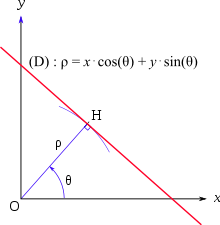

La droite en coordonnées cartésiennes correspond alors à l'équation :
$$y = \frac{\rho}{\sin\theta} - \frac{x}{\tan \theta}$$

L'idée de la transformée de Hough est de construire un histogramme qui remplit une matrice $M\times N$ (pour $M$ valeurs $\rho$ et $N$ valeurs de $\theta$). Pour chaque combinaison $\rho', \theta'$, on trace la droite correspondante dans l'image et on compte le nombre $m$ de pixels non-nuls qui se trouvent sur cette droite. On incrémente l'entrée $(\rho', \theta')$ de la matrice de cette valeur.

Une fois l'histogramme complet rempli, les maxima locaux de la matrice correspondent aux droites les plus probables dans l'image.

En pratique, on applique la transformée de Hough non pas sur l'image elle-même pas plutôt sur ses gradients ou même sur le résultat d'une détection de contours.

Voyons d'abord un exemple simple :

In [ ]:
from skimage.draw import line
from skimage.transform import hough_line
from skimage.transform import hough_line_peaks

image = np.zeros((200, 200))
idx = np.arange(25, 175)
image[idx, idx] = 255
image[line(45, 25, 25, 175)] = 255
image[line(25, 135, 175, 155)] = 255

plt.imshow(image, cmap="gray") and plt.show()

Appliquons maintenant la transformée de Hough pour tous les angles entre 0° et 360° :

In [ ]:
angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
h, theta, d = hough_line(image, theta=angles)

Le fonction `hough_line` du sous-module `transform` de `skimage` renvoie 3 valeurs :
- la transformée de Hough à proprement parler (la matrice `h`),
- les angles en radian `theta`,
- `d` la liste des valeurs des distances $\rho$.

Nous pouvons donc afficher l'image correspondant à la transformée de Hough. Les points brillants correspondant à des intersections sont les candidats $(\rho, \theta)$ les plus vraisemblables pour une droite.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax = axes.ravel()

ax[0].imshow(image, cmap="gray")
ax[0].set_title('Image de départ')
ax[0].set_axis_off()

# Échelle log pour mieux voir
ax[1].imshow(np.log(1 + h), cmap="gray")
ax[1].set_title('Transformée de Hough')
ax[1].set_xlabel('Angles (degrés)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

plt.show()

La fonction `hough_line_peaks` permet d'extraire automatiquement les maxima locaux de la transformée de Hough et donc d'obtenir les coordonnées $\rho$ et $\theta$ des droits candidates :

In [ ]:
plt.imshow(image, cmap="gray")
plt.ylim((image.shape[0], 0))
plt.axis("off")
plt.title("Lignes détectées")

for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    plt.axline((x0, y0), slope=np.tan(angle + np.pi/2))

plt.show()

Comme mentionné précédemment, en général on évite d'appliquer la transformée de Hough directement sur une image mais on s'en sert pour extraire les lignes principales après une détection de contours. En reprenant l'image de couverture des aventures de Picsou, on peut appliquer la transformée de Hough sur le résultat du filtre de Canny :

In [ ]:
angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
h, theta, d = hough_line(edges, theta=angles)

Et afficher les lignes détectées :

In [ ]:
plt.imshow(edges, cmap="gray")
plt.ylim((edges.shape[0], 0))
plt.axis("off")
plt.title("Lignes détectées")

for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    plt.axline((x0, y0), slope=np.tan(angle + np.pi/2))

plt.show()

## Transformée de Hough circulaire

La transformée de Hough ne s'applique pas uniquement à la détection de droites. En réalité, elle peut être utilisée pour estimer la présence de n'importe quelle forme géométrique paramétrique. Il existe notamment des variantes pour les cercles et les ellipses.

Inspirez-vous de l'exemple de la [documentation](https://scikit-image.org/docs/dev/auto_examples/edges/plot_circular_elliptical_hough_transform.html) et détectez des cercles (ou des ellipses) dans l'image de votre choix.

### À vous de jouer !